In [1]:
from scripts import *

ModuleNotFoundError: No module named 'scripts'

### Extract Symbol (i.e Spade/Heart etc...) from bboxed cards

In [2]:
data_loader = DataLoader()
extractor = Extractor()

image, label = data_loader[2, 1]

NameError: name 'DataLoader' is not defined

In [4]:
label

{'P1': 'JC', 'P2': '2D', 'P3': '4S', 'P4': 'JD', 'D': 4}

In [16]:
# extract dealer, cards and figure suits
dealer, cards, figure_suits = extractor(image)
print(figure_suits)

{1: {'figure': array([[[114, 108, 133],
        [225, 222, 231],
        [234, 230, 236],
        ...,
        [ 25,  40,  19],
        [ 53,  85,  50],
        [118, 168, 114]],

       [[134, 132, 138],
        [233, 233, 227],
        [233, 231, 230],
        ...,
        [ 30,  38,  28],
        [ 44,  66,  47],
        [124, 170, 124]],

       [[207, 205, 205],
        [235, 236, 227],
        [229, 225, 224],
        ...,
        [ 41,  43,  43],
        [ 34,  50,  39],
        [114, 155, 117]],

       ...,

       [[153, 155, 135],
        [ 66,  60,  53],
        [103,  96,  87],
        ...,
        [105,  54, 182],
        [128,  70, 205],
        [143,  84, 219]],

       [[146, 150, 125],
        [ 75,  71,  60],
        [ 66,  59,  50],
        ...,
        [107,  55, 192],
        [111,  56, 195],
        [124,  66, 208]],

       [[141, 150, 117],
        [ 91,  89,  71],
        [ 62,  56,  45],
        ...,
        [107,  57, 193],
        [118,  66, 204],
        [

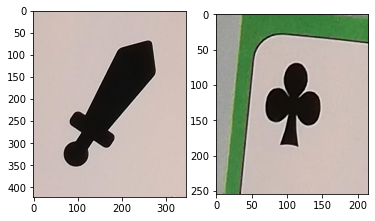

In [6]:
# usage
fig,ax = plt.subplots(1,2)

ax[0].imshow(figure_suits[1]['figure'])
ax[1].imshow(figure_suits[1]['suit'])

Apply on all cropped out images from extract main

<b> Test classifier accuracy on full dataset </b>

In [43]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_loader import DataLoader
from scripts.extract import get_color_pixels

folder = "./media/cropped_symb"

data = DataLoader()

images = []
for root, dirnames, filenames in os.walk(folder):
    for filename in filenames:
        round_, player, _ = filename.replace('r', ' ').replace('.', ' ').split()
        
        if root[-1] == '7':
            continue
        
        image = cv2.imread(os.path.join(root, filename))
        mask_red   = get_color_pixels(image, 'red')
        mask_black = get_color_pixels(image, 'black')
        image = mask_red if mask_red.sum() > mask_black.sum() else mask_black
        
        label = data[int(root[-1]), int(round_)][1]['P' + player]
        label = label[1]
        
        images.append( {'game': root[-1], 'round': round_, 'player': player, 'image': image, 'label': label})
        
images = pd.DataFrame(images)

print(images)
#data_loader = DataLoader()
#extractor = Extractor()


    game round player                                              image label
0      1    10      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
1      1    10      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C
2      1    10      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
3      1    10      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
4      1    11      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
..   ...   ...    ...                                                ...   ...
307    6     8      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
308    6     9      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
309    6     9      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
310    6     9      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
311    6     9      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C

[312 rows x 5 columns]


In [44]:
print(images)

    game round player                                              image label
0      1    10      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
1      1    10      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C
2      1    10      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
3      1    10      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
4      1    11      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
..   ...   ...    ...                                                ...   ...
307    6     8      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
308    6     9      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
309    6     9      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D
310    6     9      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     H
311    6     9      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C

[312 rows x 5 columns]


In [113]:
def get_fourier_descriptor(image, n_coefficients_to_keep = 2):
    """
    Function returning a Fourier descriptor of image made by keeping the first n_coefficients_to_keep coefficients
    (not including the bias coefficient).
    
    Args:
        image::[np.array]
            Image we want to compute the Fourier descriptor of.
        n_coefficients_to_keep::[int]
            Number of coefficients (not including the bias coefficient) to keep to make up the Fourier descriptor.
    Returns:
        fourier_descriptor::[np.array]
            Array of size (n_coefficients_to_keep, ) where each element is one Fourier descriptor coefficient.
    """
    # Compute outer contours of image.
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Isolating longest contour from the rest
    len_contours = [len(contour) for contour in contours]
    idx_longest_contour = np.argmax(len_contours)
    contour = contours[idx_longest_contour].squeeze()    
    
    # Make complex signal from contour array.
    complex_contour_signal = contour[:, 0] + 1j * contour[:, 1]
    
    # Compute fourier coefficients.
    fourier_coefficients = np.fft.fft(complex_contour_signal)
     
    # To make fourier coefficient resistant to translation, first coefficient discarded.
    fourier_coefficients = fourier_coefficients[1:]
    
    # To make fourier coefficient resistant to scaling, ratio between coefficients is used instead of actual magnitude.
    fourier_coefficients = fourier_coefficients / fourier_coefficients[n_coefficients_to_keep+1] 
    
    # To make fourier coefficient resistant to rotation, phase is discarded.
    fourier_coefficients = np.abs(fourier_coefficients)  
    
    return fourier_coefficients[:n_coefficients_to_keep]

In [165]:
hu_moments_S = []
hu_moments_C = []
hu_moments_D = []
hu_moments_H = []
FD_S = []
FD_C = []
FD_D = []
FD_H = []
for  _,img in images.iterrows(): 
    huMoments = np.array(cv2.HuMoments(cv2.moments(img["image"]))[0:6])
    FD = get_fourier_descriptor(img["image"], n_coefficients_to_keep = 10)
    if img["label"] == "S":
        hu_moments_S.append(huMoments)
        FD_S.append(FD)
    elif img["label"] == "C":
        hu_moments_C.append(huMoments)
        FD_C.append(FD)
    elif img["label"] == "H":
        hu_moments_H.append(huMoments)
        FD_H.append(FD)
    elif img["label"] == "D":
        hu_moments_D.append(huMoments)
        FD_D.append(FD)


In [166]:
hu_moments_S = np.asarray(hu_moments_S).squeeze(-1)
hu_moments_D = np.asarray(hu_moments_D).squeeze(-1)
hu_moments_C = np.asarray(hu_moments_C).squeeze(-1)
hu_moments_H = np.asarray(hu_moments_H).squeeze(-1)

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
#plt.scatter(np.asarray(hu_moments_S)[:,0],np.asarray(hu_moments_S)[:,1], c = 'red')
#plt.scatter(np.asarray(hu_moments_C)[:,0],np.asarray(hu_moments_C)[:,1], c = 'blue')
#plt.scatter(np.asarray(hu_moments_H)[:,0],np.asarray(hu_moments_H)[:,1], c = 'green')
#plt.scatter(np.asarray(hu_moments_D)[:,0],np.asarray(hu_moments_D)[:,1], c = 'yellow')
#plt.legend(['S','C','H','D'])
#plt.xlim([0,100])
#plt.show()

##SVM : 

##Moments : 

hu_moments = np.concatenate([hu_moments_S,hu_moments_C,hu_moments_H,hu_moments_D])
print(hu_moments.shape)
FD_Coeff = np.concatenate([FD_S,FD_C,FD_H,FD_D])
print(FD_Coeff.shape)
X = np.concatenate([hu_moments,FD_Coeff],axis = 1)
print(X.shape)

y = [0]*len(hu_moments_S)+[1]*len(hu_moments_C)+[2]*len(hu_moments_H)+[3]*len(hu_moments_D)
X_train,X_test, y_train, y_test = train_test_split(X,y) 

for lf in [LinearSVC(C = 0.5, random_state=0, tol=1e-5,penalty = 'l1',loss='squared_hinge',dual = False,max_iter = 7000),
          AdaBoostClassifier(),LinearDiscriminantAnalysis(),GradientBoostingClassifier()]:
    print(type(lf).__name__)
    lf.fit(X_train,y_train)
    print('train',lf.score(X_train,y_train))
    print('test',lf.score(X_test,y_test))

(312, 6)
(312, 10)
(312, 16)
LinearSVC
train 0.9444444444444444
test 0.9487179487179487
SVC
train 0.44017094017094016
test 0.3974358974358974
AdaBoostClassifier
train 0.7008547008547008
test 0.6410256410256411
LinearDiscriminantAnalysis
train 0.9444444444444444
test 0.9358974358974359
GradientBoostingClassifier
train 1.0
test 0.8589743589743589


In [163]:
lf.score(X_train,y_train)

0.9444444444444444

In [164]:
lf.score(X_test,y_test)

0.8974358974358975

In [134]:
lf.coef_

AttributeError: coef_ is only available when using a linear kernel